In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor, LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from datetime import datetime

plt.rcParams['figure.figsize'] = (10,5)

## Import dataset

In [4]:
from sklearn.datasets import load_boston
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target

In [5]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## Explore the data

In [6]:
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
boston.shape

(506, 14)

In [8]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


## Define Training and Test Validation Sets

In [9]:
# subset X (features) and y (target)
X = boston.iloc[:,:-1]
y = boston['MEDV']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 52)

In [11]:
print(f'Train Size: {X_train.shape[0]}')
print(f'Test Size: {X_test.shape[0]}')

Train Size: 404
Test Size: 102


## Assess distributions and apply transformations (if necessary)

Skew: 1.1909565912487068


count    404.000000
mean      22.466584
std        9.046733
min        5.000000
25%       17.275000
50%       21.050000
75%       24.800000
max       50.000000
Name: MEDV, dtype: float64

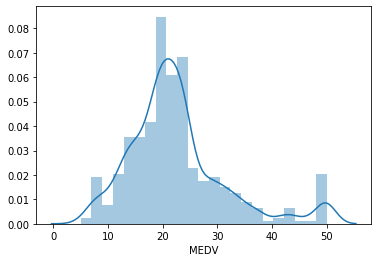

In [12]:
# target distribution
sns.distplot(y_train)
skew = y_train.skew()
print(f'Skew: {skew}')
y_train.describe()

In [13]:
# transform target (if necessary)
# y = np.log1p(y)
# y_train = np.log1p(y)
# y_test = np.log1p(y)

Skew:
CRIM       4.567133
ZN         2.205269
INDUS      0.322259
CHAS       3.941637
NOX        0.739842
RM         0.403944
AGE       -0.540963
DIS        0.991550
RAD        1.025653
TAX        0.677818
PTRATIO   -0.809830
B         -2.845400
LSTAT      0.995621
dtype: float64


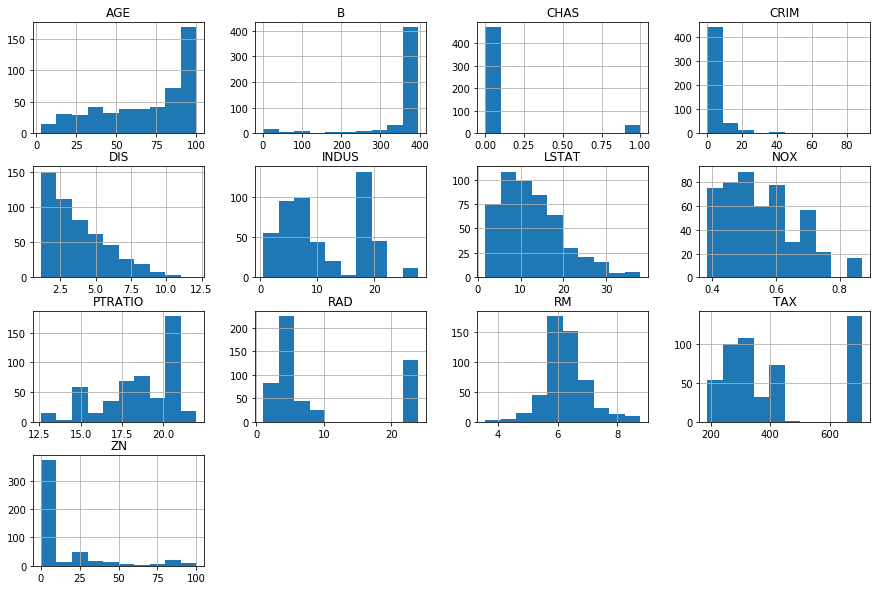

In [14]:
# feature distrubtions
skew = X_train.skew()
print(f'Skew:\n{skew}')
boston.iloc[:,:-1].select_dtypes(include = ['float','int']).hist(figsize = (15,10))
plt.show()

In [15]:
# transform skewed features (if necessary)
skew_features = list(skew.loc[abs(skew) > 0.75].index)
# skew_features = []
for feature_name in skew_features:
    X_train[f'LOG1P_{feature_name}'] = np.log1p(X_train[feature_name])
    X_train.drop([f'{feature_name}'], axis = 1, inplace = True)

for feature_name in skew_features:
    X_test[f'LOG1P_{feature_name}'] = np.log1p(X_test[feature_name])
    X_test.drop([f'{feature_name}'], axis = 1, inplace = True)

for feature_name in skew_features:
    X[f'LOG1P_{feature_name}'] = np.log1p(X[feature_name])
    X.drop([f'{feature_name}'], axis = 1, inplace = True)

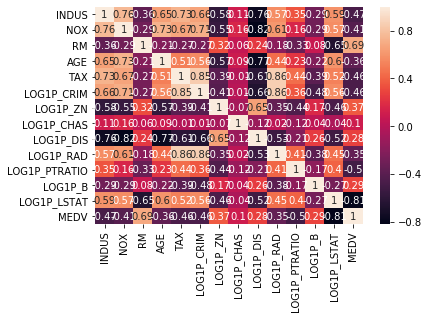

In [16]:
# correlation matrix
correlation_matrix = X_train.assign(MEDV = y_train).corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True);

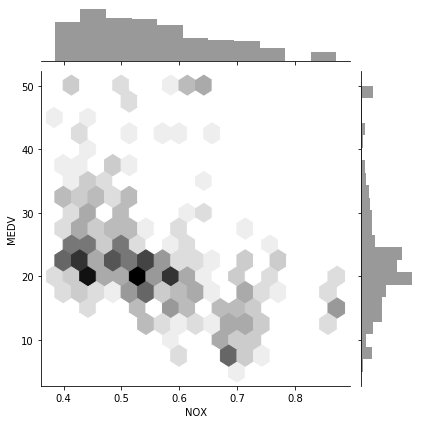

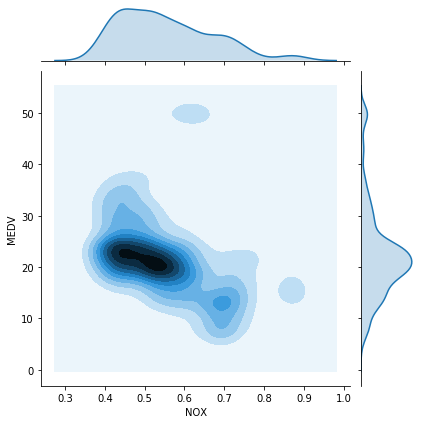

KeyError: 'CHAS'

In [17]:
# other bivariate plots
sns.jointplot(X_train['NOX'], y_train, kind="hex", color="k");
sns.jointplot(X_train['NOX'], y_train, kind="kde");
plt.show()
sns.boxplot(X_train['CHAS'], y_train);
plt.show()
sns.violinplot(X_train['CHAS'], y_train);

In [18]:
# subset features
feature_subset = ['INDUS','NOX','TAX','LOG1P_PTRATIO','LOG1P_LSTAT']
X = X[feature_subset].copy()
X_train = X_train[feature_subset].copy()
X_test = X_test[feature_subset].copy()

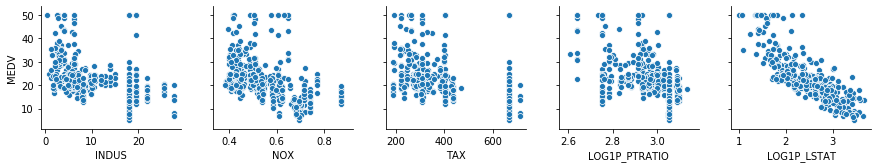

In [19]:
# pairwise plot
sns.pairplot(X_train.assign(MEDV = y_train), y_vars = ['MEDV'], x_vars = feature_subset);

## Model assessment and diagnostic functions

In [20]:
# initialize empty dataframe
metrics = pd.DataFrame()

# calculate assessment metrics (append to metrics df when finalized)
def assessment_metrics(method):
    # sample sizes
    size_train = y_train.shape[0]
    size_test = y_test.shape[0]

    # calculate R2, RMSE, and MAE
    r2_train = r2_score(y_train,y_predict_train)
    r2_test = r2_score(y_test,y_predict_test)

    rmse_train = np.sqrt(mean_squared_error(y_train,y_predict_train))
    rmse_test = np.sqrt(mean_squared_error(y_test,y_predict_test))

    mae_train = mean_absolute_error(y_train,y_predict_train)
    mae_test = mean_absolute_error(y_test,y_predict_test)

    # create dataframe
    dict = {
            'method':[method,method],
            'run_timestamp':[datetime.now(),datetime.now()],
            'sample':['train','test'],
            'size':[size_train,size_test],
            'r2':[r2_train,r2_test],
            'rmse':[rmse_train,rmse_test],
            'mae':[mae_train,mae_test]
            }

    return pd.DataFrame(dict)

In [21]:
# diagnostic and residual plots
def model_plots(actual, predicted):
    # predicted vs actuals
    plt.scatter(actual, predicted)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

    # predicted vs residuals
    residuals = actual - predicted
    scaler = StandardScaler()
    std_residuals = scaler.fit_transform(residuals.values.reshape(-1,1))
    plt.scatter(predicted, std_residuals)
    plt.xlabel('Predicted')
    plt.ylabel('STD Residuals')
    plt.hlines(0, predicted.min(), predicted.max(), linestyles='dotted')
    plt.show()

    # residual distribution
    plt.hist(std_residuals)
    plt.xlabel('STD Residuals')
    plt.show()

    # residual ordered plot
    plt.scatter(actual.index, std_residuals)
    plt.xlabel('Index')
    plt.ylabel('STD Residuals')

In [22]:
# learning curve
def model_learning_curve(model,X,y):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=3, random_state=52)

    train_scores_ave = train_scores.mean(axis=1)
    val_scores_ave = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_ave, '-x', label='training')
    plt.plot(train_sizes, val_scores_ave, '-o', label='validation')
    plt.ylabel('R2')
    plt.xlabel('training size')
    plt.legend()

## Linear Regression</br>
Use HuberRegressor for robust regression, less sesnsitive to outliers

In [23]:
# fit model
model = LinearRegression()
# model = HuberRegressor()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

In [25]:
# list coefficients in readable format
pd.DataFrame(list(zip(pd.Index(['Intercept']).append(X_train.columns),
             np.append(model.intercept_,model.coef_))), 
             columns=['Variable', 'Coef']).sort_values(by='Coef').sort_index()

,Variable,Coef
0,Intercept,101.004901
1,INDUS,0.077798
2,NOX,3.460642
3,TAX,-0.002808
4,LOG1P_PTRATIO,-16.421288
5,LOG1P_LSTAT,-12.738390


In [26]:
assessment_metrics('ols_sklearn')

,method,run_timestamp,sample,size,r2,rmse,mae
0,ols_sklearn,2020-05-15 15:25:07.981598,train,404,0.693600,5.001470,3.673302
1,ols_sklearn,2020-05-15 15:25:07.981598,test,102,0.706382,5.290875,3.661846


In [27]:
# append to metrics df
metrics = metrics.append(assessment_metrics('ols_sklearn'), ignore_index=True)

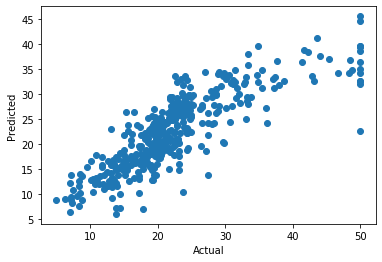

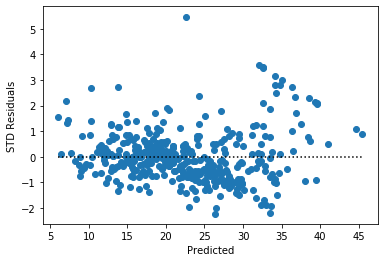

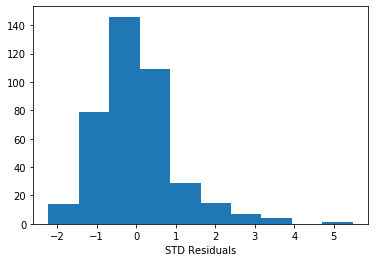

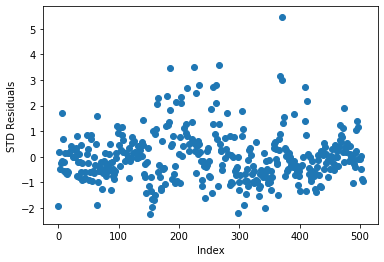

In [28]:
model_plots(y_train,y_predict_train)

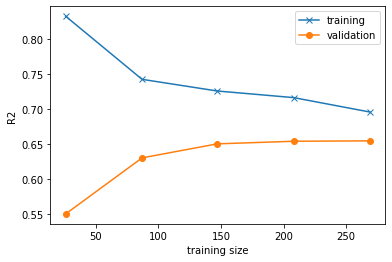

In [29]:
model_learning_curve(model,X_train,y_train)

## Ridge

In [70]:
kf = 5
model = Pipeline([('scaler', StandardScaler()),
        # ('polynomial_features', PolynomialFeatures()),
        ('ridge', Ridge())])

params = {
    # 'polynomial_features__degree': [1, 2, 3],
    'ridge__alpha': np.geomspace(1e-5, 5, 50)
}

scorer = make_scorer(r2_score)
grid = GridSearchCV(model, params, cv=kf, scoring = scorer)

In [71]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'ridge__alpha':...
       5.26958397e-02, 6.88782080e-02, 9.00300207e-02, 1.17677345e-01,
       1.53814887e-01, 2.01049909e-01, 2

In [72]:
grid.best_score_

0.6665899538578011

In [73]:
grid.best_params_

{'ridge__alpha': 3.8252911353590915}

In [83]:
# get list of poly columns
# degree = grid.best_params_.get('polynomial_features__degree')
# poly = PolynomialFeatures(degree)
# poly_fit = poly.fit(X_train)
# columns = poly_fit.get_feature_names(X_train.columns)
# columns[0] = 'Intercept'

In [76]:
# list coefficients in readable format
columns = pd.Index(['Intercept']).append(X_train.columns)
pd.DataFrame(list(zip(poly_columns,
             np.append(grid.best_estimator_.named_steps['ridge'].intercept_,grid.best_estimator_.named_steps['ridge'].coef_))), 
             columns=['Variable', 'Coef']).sort_values(by='Coef').sort_index()

,Variable,Coef
0,Intercept,22.466584
1,INDUS,0.491070
2,NOX,0.363021
3,TAX,-0.464569
4,LOG1P_PTRATIO,-1.890420
5,LOG1P_LSTAT,-6.729338


In [77]:
y_predict_train = grid.predict(X_train)
y_predict_test = grid.predict(X_test)

In [78]:
assessment_metrics('Ridge')

,method,run_timestamp,sample,size,r2,rmse,mae
0,Ridge,2020-05-15 15:38:56.920353,train,404,0.693512,5.002193,3.667786
1,Ridge,2020-05-15 15:38:56.920353,test,102,0.705691,5.297096,3.652652


In [79]:
# append to metrics df
# metrics = metrics.append(assessment_metrics('ols_sklearn'), ignore_index=True)

In [80]:
# model_plots(y_train, y_predict_train)

In [81]:
# model_learning_curve(model, X_train, y_train)

Text(0.5, 0, '$\\alpha$')

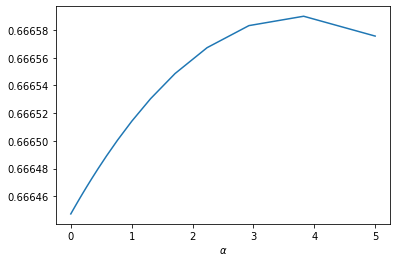

In [82]:
plt.plot(grid.cv_results_['param_ridge__alpha'].data, 
         grid.cv_results_['mean_test_score']);
plt.xlabel('$\\alpha$')

## Lasso

## Polynomial Regression

In [57]:
degree = 2

poly = PolynomialFeatures(degree)
poly_fit = poly.fit(X_train[feature_subset])
X_train_poly = poly.fit_transform(X_train[feature_subset])
X_test_poly = poly.fit_transform(X_test[feature_subset])

model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
y_predict_train = model.predict(X_train_poly)
y_predict_test = model.predict(X_test_poly)

In [65]:
# list coefficients in readable format
poly_list = poly_fit.get_feature_names(X_train[feature_subset].columns)
poly_list[0] = 'Intercept'
pd.DataFrame(list(zip(poly_list,np.append(model.intercept_,model.coef_))), 
             columns=['Variable', 'Coef']).sort_values(by='Coef').sort_index()

,Variable,Coef
0,Intercept,62.112598
1,INDUS,0.000000
2,NOX,-0.899495
3,TAX,282.304158
4,PTRATIO,-0.277661
5,LSTAT,-3.064412
6,INDUS^2,-3.700121
7,INDUS NOX,-0.014868
8,INDUS TAX,3.133756
9,INDUS PTRATIO,0.000461


In [66]:
assessment_metrics('poly')

,method,run_timestamp,sample,size,r2,rmse,mae
0,poly,2020-05-11 16:01:01.737662,train,404,0.768501,4.347381,3.191502
1,poly,2020-05-11 16:01:01.737662,test,102,0.772482,4.657403,3.347794


In [67]:
# model_plots(y_train, y_predict_train)

## OLS - statsmodels</br>
Nicer output statistical inference and interpretation

In [268]:
# fit model (subset X, user correlation matrix and plots as guide)
X_train_sm = sm.add_constant(X_train[feature_subset])
X_test_sm = sm.add_constant(X_test[features])
model = sm.OLS(y_train, X_train_sm)
results = model.fit()

In [269]:
print(results.summary())

OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     116.0
Date:                Mon, 11 May 2020   Prob (F-statistic):           1.88e-75
Time:                        13:59:05   Log-Likelihood:                -1280.9
No. Observations:                 404   AIC:                             2574.
Df Residuals:                     398   BIC:                             2598.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.9903      3.491     15.750      0.000      48.126      61.854
I

In [270]:
y_predict_train = results.predict(X_train_sm)
y_predict_test = results.predict(X_test_sm)

In [271]:
residuals = results.resid

In [272]:
assessment_metrics('ols_statsmodels')

,method,run_timestamp,sample,size,r2,rmse,mae
0,ols_statsmodels,2020-05-11 13:59:07.667756,train,404,0.593124,5.763476,4.126094
1,ols_statsmodels,2020-05-11 13:59:07.667756,test,102,0.646864,5.802393,3.845983


In [267]:
# model_plots(y_train, y_predict_train)

## Retrain and save final model

In [ ]:
# model.fit(X, y)

In [ ]:
# pickle.dump(model, open('final_model.pkl', 'wb'))